In [32]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant

In [263]:
behav_size = 1
sigmoid_k = 200000000000
sigmoid_b = 20
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# B1 = np.random.rand(1, behav_size)
# B2 = np.random.rand(1, behav_size)
B1 = np.array([[1]])
B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.1])
T2 = np.array([.1])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 887

 Sigmoid Model Agents (Error Relative to Expectation)


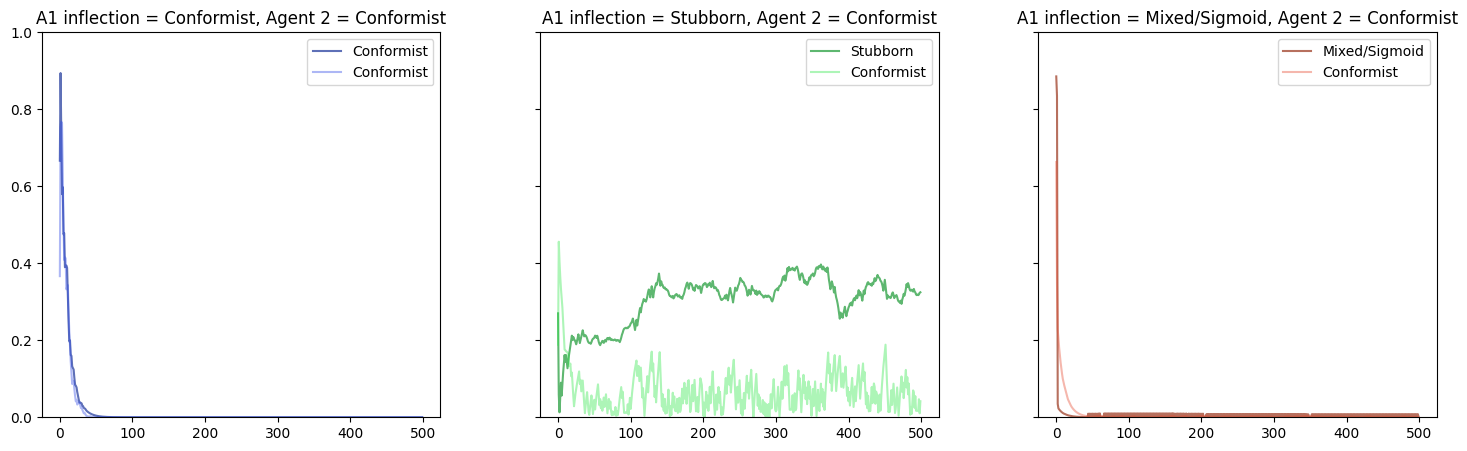

In [264]:
seed = random.randrange(1000)
# seed = 330
np.random.seed(seed)
print("Seed was:", seed)

w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 500
time = [i for i in range(trials)]


color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

agent1_pref_errors = []
agent2_pref_errors = []

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    sigmoid_8_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_pref_error = []
    agent2_pref_error = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        agent1_pref_error.append(np.sum(np.absolute(R1-b2))/len(agent1.get_reference()[0]))
        agent2_pref_error.append(np.sum(np.absolute(R2-b1))/len(agent2.get_reference()[0]))
        # if agents_label[param] == "Stubborn":
        #    print("R1: ", R1)
        #    print("reference: ", agent1.get_reference())
        #    print("np.absolute(R1-b2): ", np.absolute(R1-b2))
        #    print("ref - sensory: ", np.absolute(agent1.get_reference() - b2))
        #    print("pref sum: ", sum(np.absolute(R1-b2)[0]))
        #  print("agent1 pref error: ", np.sum(np.absolute(R1-b2))/len(agent1.get_reference()[0]))

        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        # agent1_control.append(agent1.get_output())
        # agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        # agent1_behaviors.append(b1)
        # agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_error.append(np.sum(np.absolute(agent1.get_error()))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.absolute(agent2.get_error()))/len(agent2.get_error()[0]))
        
        # if agents_label[param] == "Stubborn":
          #  print("abs agent1.get_error: ", np.absolute(agent1.get_error()))
          #  print("error sum: ", np.sum(np.absolute(agent1.get_error())))
          #  print("agent1 error: ", np.sum(np.absolute(agent1.get_error()))/len(agent1.get_reference()[0]))
          #  print("---")
        

        # agent1_reference.append(agent1.get_reference()[0])
        # agent2_reference.append(agent2.get_reference()[0])
        
    agent1_pref_errors.append(agent1_pref_error)
    agent2_pref_errors.append(agent2_pref_error)
    
    ai = tups[ix][1]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    ax[ai].set_title('A1 inflection = {}, Agent 2 = Conformist'.format(agents_label[param]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')

print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()

In [237]:
behav_size = 1
sigmoid_k = 32
sigmoid_b = 5
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# B1 = np.random.rand(1, behav_size)
# B2 = np.random.rand(1, behav_size)
B1 = np.array([[1]])
B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.6])
T2 = np.array([.6])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 168
(0, 0)
(0, 1)
(0, 2)

 Sigmoid Model Agents (Error Relative to Expectation)


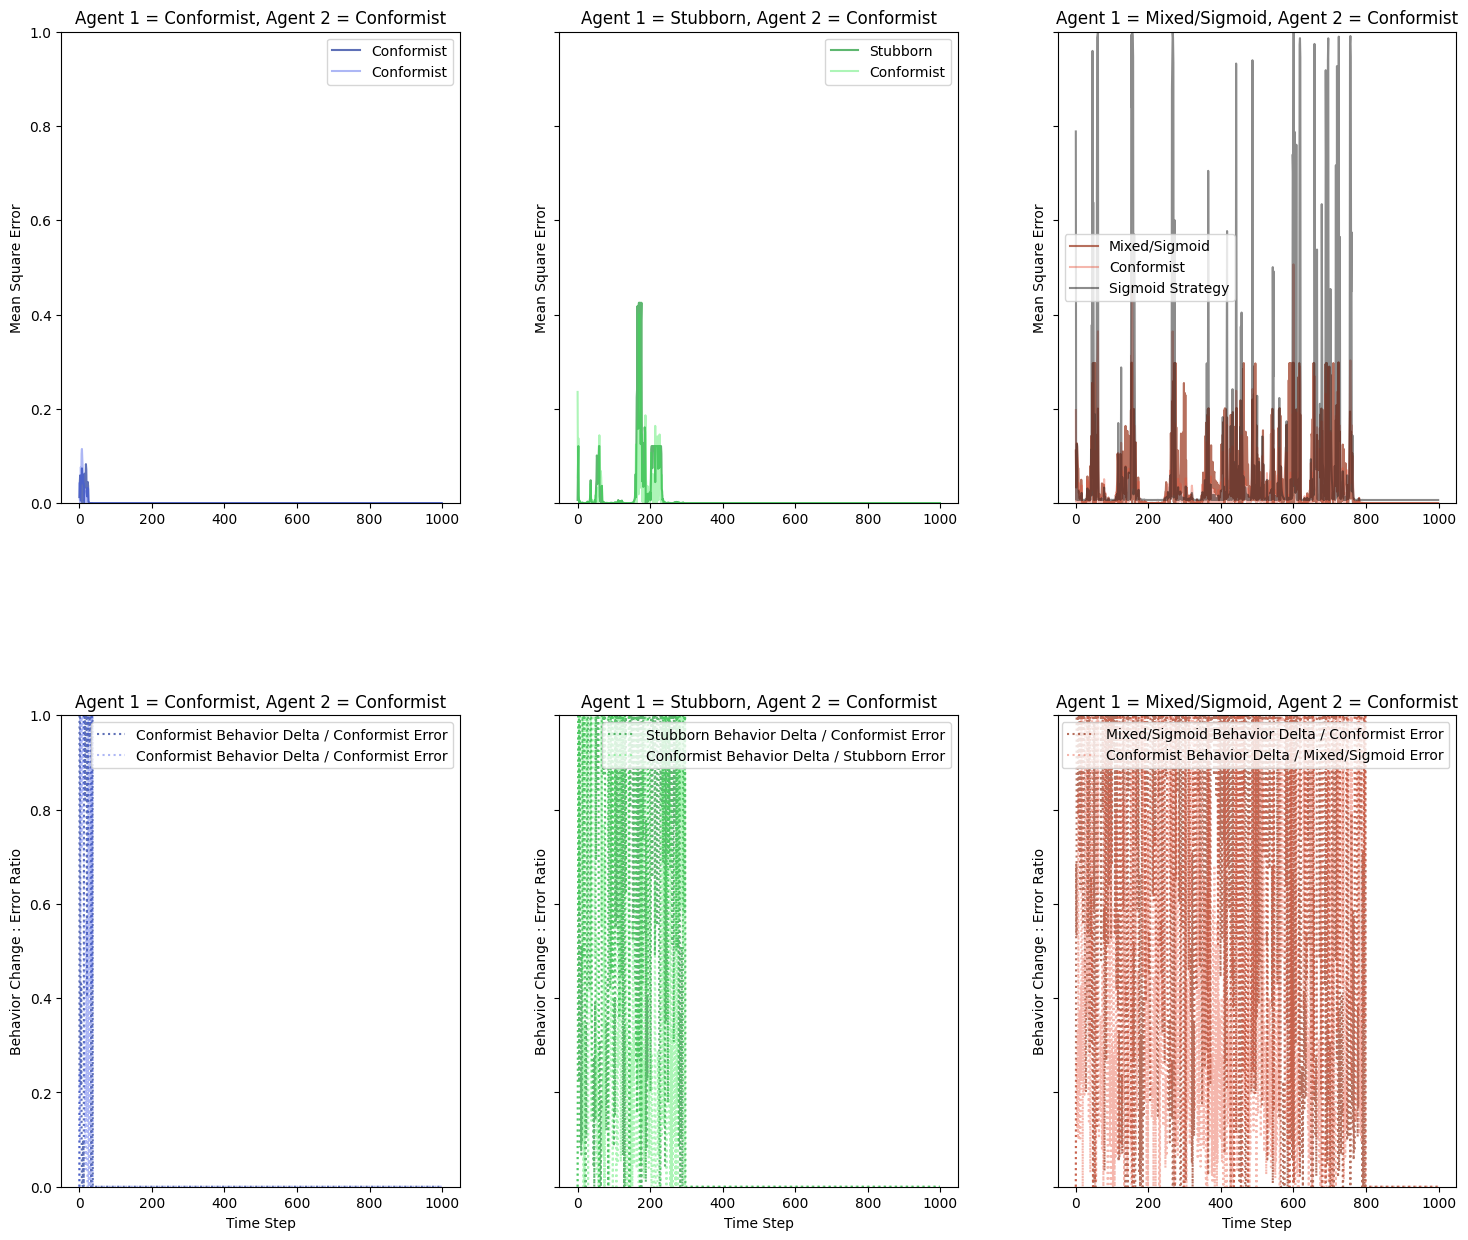

In [238]:
seed = random.randrange(1000)
# seed = 186
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_raw_error.append(agent1.get_error()[0][0])
        agent2_raw_error.append(agent2.get_error()[0][0])
        # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
        #   agent1_raw_error.append(b1[0][0]+0.001)
        # else:
        #   agent1_raw_error.append(agent1.get_error()[0][0])
        # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
        #    agent2_raw_error.append(b2[0][0]+0.001)
        # else:
        #   agent2_raw_error.append(agent2.get_error()[0][0])
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    print(ai)
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    if agents_label[param] == "Mixed/Sigmoid": 
      ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    # ax[ai].set_xlabel("Time Step")

    # derivative charts
    dx = 1
    # b1_flat = [i[0] for i in agent1_control]
    # b2_flat = [i[0] for i in agent2_control]
    b1_flat = [i[0][0]for i in agent1_behaviors]
    b2_flat = [i[0][0]for i in agent2_behaviors]
    # d_behav1 = abs(np.gradient(b1_flat, dx))
    # d_behav2 = abs(np.gradient(b2_flat, dx))
    d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
    d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
    agent1_raw_error.insert(-1, 1)
    agent2_raw_error.insert(-1, 1)
    agent1_raw_error_shifted = agent1_raw_error[1:]
    agent2_raw_error_shifted = agent2_raw_error[1:]
    if agents_label[param] == 'Stubborn':
       saved = d_behav1/agent1_error
      #  print(agent2_error/(d_behav2+0.01))
    # ax[(ai[0]+1,ai[1])].plot(time, d_behav1, color=color, linestyle='--', label="{} Change in Behavior".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].plot(time, d_behav2, color=color_c, linestyle='--', label="Conformist Change in Behavior")
    # ax[(ai[0]+1,ai[1])].plot(time, agent1_error, color=color,  label="{} Error".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].plot(time, agent2_error, color=color_c, label="Conformist Error")
    ax[(ai[0]+1,ai[1])].plot(time, abs(d_behav1/agent2_raw_error_shifted), color=color, linestyle=':', label="{} Behavior Delta / Conformist Error".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].plot(time, abs(d_behav2/agent1_raw_error_shifted), color=color_c, linestyle=':', label="Conformist Behavior Delta / {} Error".format(agents_label[param]))
    # if agents_label[param] == "Mixed/Sigmoid": 
    #   ax[(ai[0]+1,ai[1])].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Change : Error Ratio")
    ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")
# plt.text(-55, 4, "Different Agent Strategies for Stabilizing Behavior", fontsize=14)
# plt.text(-55, 1.85, "Tracing the Ratio of Change in Behavior and the Error of a Counterpart", fontsize=14)
print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()